# Solving Simple Two-Country Model with CBDC 

## Darren Chang

## Section 2.1

This file is to solve the basic model described in section 2.1 of *Central Bank Digital Currency in Open Economies*. The model is a CIA open economy RBC model in which the home economy implements CBDC. The home economy is modeled as a small economy while the foreign economy is a large open economy. We begin with the baseline model of the economy, which is a cash and bonds economy without CBDC before moving on to a model with CBDC and bonds.

In [1]:
## imports
import numpy as np
import pandas as pd
import linearsolve as ls
from scipy.optimize import root,fsolve,broyden1,broyden2
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

In [2]:
# set parameters
A = 1
alpha = 0.32
delta = 0.1
sigma = 2
# pi = 0.01 # interest = mu, rate of money growth
beta = 0.971 # (1+pi)/(1+rstar)
bbar = 0.7442 # debt

## cbdc parameters
eta = 1.05 # Transaction efficiency for cash
theta1 = 2 # level parameter for transaction cost fxn
gamma = 2 # transaction cost for consumption goods
mu = 0.02 # growth rate of money supply


omega = 1.455 # Frisch elasticity from Mendoza 1991
phi = 0.028# capital adjustment cost
psi1 = 0.000742 # debt elasticity of interest rate
rho = 0.42 # persistence of TFP shock
etat = 0.0129 # standard deviation of innovation to TFP shock

In [26]:
# solve for deterministic steady state
pi_ss = mu
rstar_ss = (1+pi_ss)/beta-1
kappa_ss = ((1/beta-1+delta)/alpha)**(1/(alpha-1))
n_ss = ((1-alpha)*kappa_ss**alpha)**(1/(omega-1))
k_ss = kappa_ss*n_ss
r_ss = rstar_ss
y_ss = A*kappa_ss**alpha*n_ss
I_ss = delta*k_ss

def calc_c(c):
    return c*pi_ss-c+theta1*c**gamma*(c/(1+pi_ss))**eta-(bbar*(rstar_ss-pi_ss)/(1+pi_ss)-kappa_ss**alpha*n_ss-delta*k_ss)
                                                  
c_ss = root(calc_c, 1, method = 'lm')['x'][0]
h_ss = c_ss*(1+pi_ss)
la_ss = (c_ss-n_ss**omega/omega)**(-sigma)/(1+theta1*gamma*(c_ss**(gamma-1))/h_ss**eta) # MU of wealth

In [27]:
# define equilibrium equations
def equilibrium_equations(variables_forward,variables_current,parameters):
    
    # Parameters 
    p = parameters
    
    # Variables
    fwd = variables_forward
    cur = variables_current
    
    # MU of wealth
    e1 = (cur.c-cur.n**p.omega/p.omega)**(-p.sigma)/(1+p.theta1*p.gamma*cur.c**(p.gamma-1)/cur.h**p.eta)- cur.la
    
    # Evolution of debt
    e2 = -fwd.b+(1+cur.r)*cur.b/(1+cur.pi)+cur.c+cur.I+p.phi/2*(fwd.k-cur.k)**2-cur.y-fwd.h+cur.h/(1+cur.pi)+p.theta1*cur.c**p.gamma/(cur.h**p.eta) # cur.pi
    
    # output
    e3 = -cur.y+A*cur.k**p.alpha*cur.n**(1-p.alpha)

    # FOC w.r.t. n
    e4 = -cur.n**(p.omega-1)+(1-p.alpha)*cur.A*(cur.k/cur.n)**p.alpha

    # FOC w.r.t. bonds
    e5 = -cur.la + p.beta*(1+cur.r)/(1+fwd.pi)*fwd.la

    # FOC w.r.t. capital
    e6 = -cur.la*(1+p.phi*(fwd.k-cur.k))+p.beta*fwd.la*(1-p.delta+p.alpha*cur.A*(fwd.k/fwd.n)**(p.alpha-1)+p.phi*(fwd.kfu-cur.k))

    # Country premium
    e7 = -fwd.r+rstar_ss+p.psi1*(np.exp(fwd.b-bbar)-1)

    # Investment
    e8 = -cur.I+fwd.k-(1-p.delta)*cur.k

    # productivity
    e9 = -fwd.A+p.rho*cur.A

    # make kfu=kp
    e10 = -cur.kfu+fwd.k
    
    # foc for h
    e11 = -cur.la+p.beta*fwd.la*(1/(1+fwd.pi)-p.eta*p.theta1*(fwd.c**p.gamma)*(cur.h**(-p.eta-1)))

    # money supply
    e12 = -fwd.h + (1+p.mu)/(1+cur.pi)*cur.h

    return np.array([
        e1,
        e2,
        e3,
        e4,
        e5,
        e6,
        e7,
        e8,
        e9,
        e10,
        e11,
        e12
    ])

In [28]:
parameter_vals = [alpha, delta, sigma, beta, bbar, eta, theta1, gamma, mu, omega, phi, psi1, rho, etat] 
parameter_names = ['alpha', 'delta', 'sigma', 'beta', 'bbar', 'eta', 'theta1', 'gamma', 'mu', 'omega', 'phi', 'psi1', 'rho', 'etat']
parameters = pd.Series(parameter_vals, index = parameter_names)

In [29]:
model = ls.model(equations = equilibrium_equations,
                 n_states=4,
                 var_names=['A', 'la', 'c', 'k', 'kfu', 'h', 'n', 'b', 'y', 'I', 'r', 'pi'],
                 shock_names= ['ea'],
                 parameters = parameters) # inflation shock?

In [30]:
ss = [1, la_ss, c_ss, k_ss, k_ss, h_ss, n_ss, bbar, y_ss, I_ss, r_ss, pi_ss] # tau_ss

In [31]:
model.set_ss(ss)

In [32]:
print(model.ss)

A      1.000000
la     1.482789
c      0.414035
k      4.101302
kfu    4.101302
h      0.422316
n      1.088829
b      0.744200
y      1.664438
I      0.410130
r      0.050463
pi     0.020000
dtype: float64


In [33]:
# test rank conditions
# z11 = z[0:4,0:4]
# z11
# np.linalg.matrix_rank(z11)

In [34]:
model.approximate_and_solve(True)
model.impulse(T=15,t0=0,shocks = [-0.01], percent = True, diff = True)

In [35]:
model.irs['ea'].head(10)

,ea,A,la,c,k,kfu,h,n,b,y,I,r,pi
0,-1.0,-1.000000,0.000000,0.000000,0.000000,-2.206608,0.729445,-1.290323,10.443212,-0.877419,-22.066082,11.125193,61.512772
1,0.0,-0.420000,0.281193,-3.323257,-2.681402,-2.719331,0.039328,-1.649095,5.684814,-1.979433,-3.060688,10.532051,-4.977036
2,0.0,-0.176400,0.256005,-7.616200,-4.555282,-2.064731,-0.292305,-2.108504,2.656266,-2.891473,20.350228,5.345560,-26.334634
3,0.0,-0.074088,0.178089,-6.688561,-3.801641,-1.342048,-0.276555,-1.665307,1.258827,-2.348934,20.794291,3.621710,-23.441207
4,0.0,-0.031117,0.111309,-4.470906,-2.511026,-0.808067,-0.197714,-1.076962,0.600110,-1.535862,14.518572,1.808817,-16.263084
5,0.0,-0.013069,0.065453,-2.795769,-1.552113,-0.465182,-0.123895,-0.657736,0.289869,-0.943937,9.317201,1.104106,-10.112413
6,0.0,-0.005489,0.037158,-1.617441,-0.895396,-0.260121,-0.073588,-0.376795,0.140712,-0.542747,5.457352,0.549391,-5.946304
7,0.0,-0.002305,0.020563,-0.921098,-0.507249,-0.142575,-0.041755,-0.212419,0.069094,-0.306765,3.139495,0.317569,-3.367328
8,0.0,-0.000968,0.011197,-0.504930,-0.277833,-0.077033,-0.023235,-0.115968,0.034055,-0.167765,1.730174,0.158130,-1.864156
9,0.0,-0.000407,0.006016,-0.275811,-0.151310,-0.041181,-0.012638,-0.063001,0.016946,-0.091260,0.949974,0.088455,-1.013487


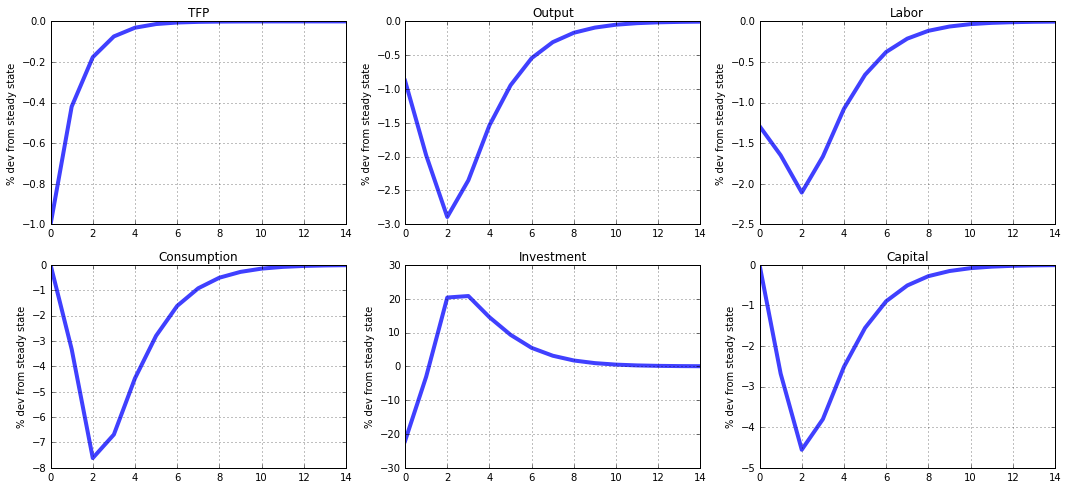

In [13]:
# Create figure. PROVIDED
fig = plt.figure(figsize=(18,8))

# TFP
ax = fig.add_subplot(2,3,1)
ax.plot(model.irs['ea']['A'],'b',lw=4,alpha=0.75)
ax.set_title('TFP')
ax.set_ylabel('% dev from steady state')
# ax.set_ylim([-1.3, 0.3])
ax.grid()

# output
ax = fig.add_subplot(2,3,2)
ax.plot(model.irs['ea']['y'],'b',lw=4,alpha=0.75)
ax.set_title('Output')
ax.set_ylabel('% dev from steady state')
# ax.set_ylim([-2.5,0.5])
ax.grid()

# labor
ax = fig.add_subplot(2,3,3)
ax.plot(model.irs['ea']['n'],'b',lw=4,alpha=0.75)
ax.set_title('Labor')
ax.set_ylabel('% dev from steady state')
# ax.set_ylim([-2.0,0.5])
ax.grid()

# consumption
ax = fig.add_subplot(2,3,4)
ax.plot(model.irs['ea']['c'],'b',lw=4,alpha=0.75)
ax.set_title('Consumption')
ax.set_ylabel('% dev from steady state')
# ax.set_ylim([-5.0,0.5])
ax.grid()

# investment
ax = fig.add_subplot(2,3,5)
ax.plot(model.irs['ea']['I'],'b',lw=4,alpha=0.75)
ax.set_title('Investment')
ax.set_ylabel('% dev from steady state')
# ax.set_ylim([-22.0,17.0])
ax.grid()

# capital
ax = fig.add_subplot(2,3,6)
ax.plot(model.irs['ea']['k'],'b',lw=4,alpha=0.75)
ax.set_title('Capital')
ax.set_ylabel('% dev from steady state')
# ax.set_ylim([-20, 3.0])
ax.grid()

# fig.tight_layout()

In [14]:
fig.savefig("bm_irf.png")

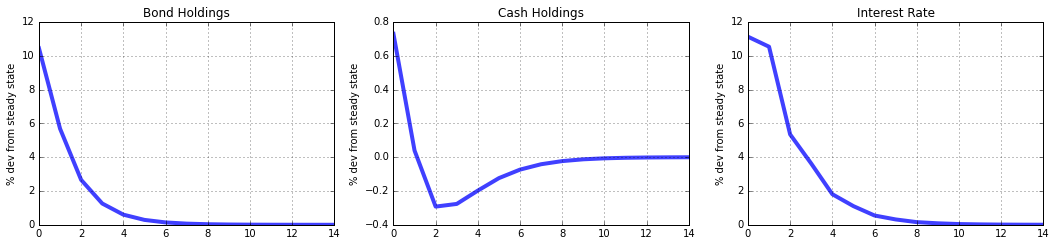

In [15]:
fig2 = plt.figure(figsize=(18,8))

# bond
ax = fig2.add_subplot(2,3,1)
ax.plot(model.irs['ea']['b'],'b',lw=4,alpha=0.75)
ax.set_title('Bond Holdings')
ax.set_ylabel('% dev from steady state')
# ax.set_ylim([-0.5, 8.5])
ax.grid()

# cash
ax = fig2.add_subplot(2,3,2)
ax.plot(model.irs['ea']['h'],'b',lw=4,alpha=0.75)
ax.set_title('Cash Holdings')
ax.set_ylabel('% dev from steady state')
# ax.set_ylim([-1.5,0.5])
ax.grid()

# r
ax = fig2.add_subplot(2,3,3)
ax.plot(model.irs['ea']['r'],'b',lw=4,alpha=0.75)
ax.set_title('Interest Rate')
ax.set_ylabel('% dev from steady state')
# ax.set_ylim([-0.015,0.008])
ax.grid()


# fig2.tight_layout()

In [16]:
fig2.savefig("bm_irf_2.png")

In [23]:
model.impulse(T=15,t0=0,shocks = [-0.01], percent = False, diff = True)

In [24]:
model.irs['ea'].head(10)

,ea,A,la,c,k,kfu,h,n,b,y,I,r,pi
0,-0.01,-0.010000,0.000000,0.000000,0.000000,-0.022066,0.007294,-0.012903,0.104432,-0.008774,-0.220661,0.111252,0.615128
1,0.00,-0.004200,0.002812,-0.033233,-0.026814,-0.027193,0.000393,-0.016491,0.056848,-0.019794,-0.030607,0.105321,-0.049770
2,0.00,-0.001764,0.002560,-0.076162,-0.045553,-0.020647,-0.002923,-0.021085,0.026563,-0.028915,0.203502,0.053456,-0.263346
3,0.00,-0.000741,0.001781,-0.066886,-0.038016,-0.013420,-0.002766,-0.016653,0.012588,-0.023489,0.207943,0.036217,-0.234412
4,0.00,-0.000311,0.001113,-0.044709,-0.025110,-0.008081,-0.001977,-0.010770,0.006001,-0.015359,0.145186,0.018088,-0.162631
5,0.00,-0.000131,0.000655,-0.027958,-0.015521,-0.004652,-0.001239,-0.006577,0.002899,-0.009439,0.093172,0.011041,-0.101124
6,0.00,-0.000055,0.000372,-0.016174,-0.008954,-0.002601,-0.000736,-0.003768,0.001407,-0.005427,0.054574,0.005494,-0.059463
7,0.00,-0.000023,0.000206,-0.009211,-0.005072,-0.001426,-0.000418,-0.002124,0.000691,-0.003068,0.031395,0.003176,-0.033673
8,0.00,-0.000010,0.000112,-0.005049,-0.002778,-0.000770,-0.000232,-0.001160,0.000341,-0.001678,0.017302,0.001581,-0.018642
9,0.00,-0.000004,0.000060,-0.002758,-0.001513,-0.000412,-0.000126,-0.000630,0.000169,-0.000913,0.009500,0.000885,-0.010135


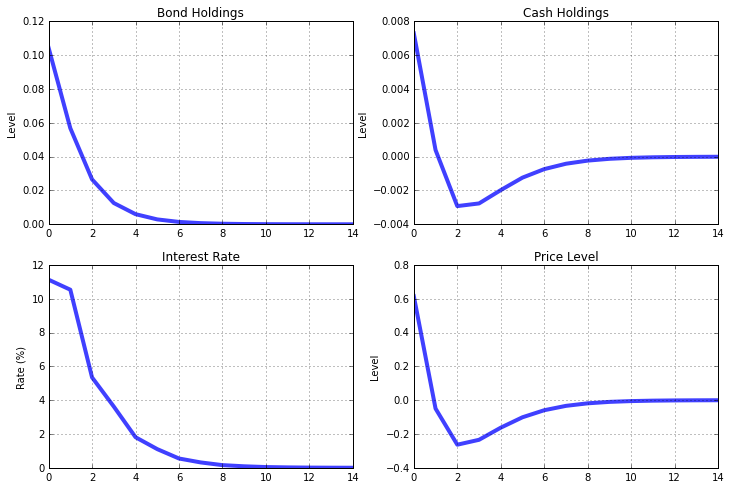

In [25]:
fig3 = plt.figure(figsize=(12,8))

# bond
ax = fig3.add_subplot(2,2,1)
ax.plot(model.irs['ea']['b'],'b',lw=4,alpha=0.75)
ax.set_title('Bond Holdings')
ax.set_ylabel('Level')
# ax.set_ylim([-0.5, 8.5])
ax.grid()

# cash
ax = fig3.add_subplot(2,2,2)
ax.plot(model.irs['ea']['h'],'b',lw=4,alpha=0.75)
ax.set_title('Cash Holdings')
ax.set_ylabel('Level')
# ax.set_ylim([-3.8,0.7])
ax.grid()

# r
ax = fig3.add_subplot(2,2,3)
ax.plot([100*x for x in model.irs['ea']['r']],'b',lw=4,alpha=0.75)
# ax.plot(model.irs['ea']['r'], 'b', lw = 4, alpha =0.75)
ax.set_title('Interest Rate')
ax.set_ylabel('Rate (%)')
# ax.set_ylim([2.5,4.8])
ax.grid()

# pi
ax = fig3.add_subplot(2,2,4)
ax.plot(model.irs['ea']['pi'], 'b', lw = 4, alpha =0.75)
ax.set_title('Price Level')
ax.set_ylabel('Level')
# ax.set_ylim([2.5,4.8])
ax.grid()

# fig3.tight_layout()

In [20]:
fig3.savefig("bm_irf_3.png")

In [37]:
import scipy.linalg as la
s,t,alpha,beta,q,z = la.ordqz(A=model.a,B=model.b,sort='ouc')